# Figure One: Alignment (in Carrington Longitude)

- Panel One: PSP Velocity & SolO Velocity 
- Panel Two: PSP Cross Helicity 
- Panel Three: PSP & SolO Position as function of velocity

## Imports

In [23]:
import sys, os
import astropy.units as u

import datetime
import numpy as np
import pandas as pd
import scipy.constants as con
from scipy import stats
import scipy.stats as stats
from scipy.interpolate import interp1d
from pandas.tseries.frequencies import to_offset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


import sunpy
import astrospice
from astropy.time import Time
from pyspedas import time_string

import tools.utilities as utils
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs
# from mhd.psipy.model import MASOutput
# from psipy.data import sample_data

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
scol = 'violet'
hcol = 'lightblue'
pcol = 'lightgreen'
aa = 0.6
lw=2
clon = c[0]
clat = c[1]
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring'] # velocity, density, magnetic field

# REGIONS
loc_hcs = [112, 115]
pseud = [166.5, 173]
fsw = [70, 85]
ssw = [150, 166.5]
sasw = [173, 185]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

02-Aug-23 14:49:01: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [3]:
# regular data
parker = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parker.csv')
orbiter = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiter.csv')
abun = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abun.csv')
smag = pd.read_csv('/Users/tamarervin/e11_conjunction/results/solo_mag.csv')
merged_df = pd.read_csv('/Users/tamarervin/e11_conjunction/results/merged_df.csv')
pss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/pss.csv')

# timesampled data
parkerdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parkerdownt.csv')
orbiterdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiterdownt.csv')
abundownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abundownt.csv')
smagdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/smagdownt.csv')

# longitudinally sampled data
parkerdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parkerdownl.csv')
orbiterdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiterdownl.csv')
abundownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abundownl.csv')
smagdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/smagdownl.csv')

# PFSS/MHD data
tracerdf = pd.read_csv('/Users/tamarervin/e11_conjunction/mhd/mhd_footpoints.dat', sep='\s+') 
so_tracerdf = pd.read_csv('/Users/tamarervin/e11_conjunction/mhd/so_mhd_footpoints.dat', sep='\s+')
pfss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/psp_pfss.csv')
so_pfss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/so_pfss.csv')


## Generate Position

In [5]:
def gen_dt_arr(dt_init,dt_final,cadence_days=1) :
    """
    Get array of datetime.datetime from {dt_init} to {dt_final} every 
    {cadence_days} days
    """
    dt_list = []
    while dt_init < dt_final :
        dt_list.append(dt_init)
        dt_init += datetime.timedelta(days=cadence_days)
    return np.array(dt_list)

# Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py
from astropy.coordinates import SkyCoord

@u.quantity_input
def delta_long(r:u.R_sun,
               r_inner=2.0*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to(u.deg)

def ballistically_project(skycoord,r_inner = 2.0*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [8]:
dt_start,dt_end = datetime.datetime(2022,2,18),datetime.datetime(2022,3,4)
dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', dt_common

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter', dt_common

)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

# get velocity
psp_vr_ts = [int(datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp()) for dt in parker.Time]
psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_ts = [int(datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').timestamp()) for dt in orbiter.Time]
solo_vr_common = interp1d(solo_vr_ts,orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s

# projection
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

## Create Plot

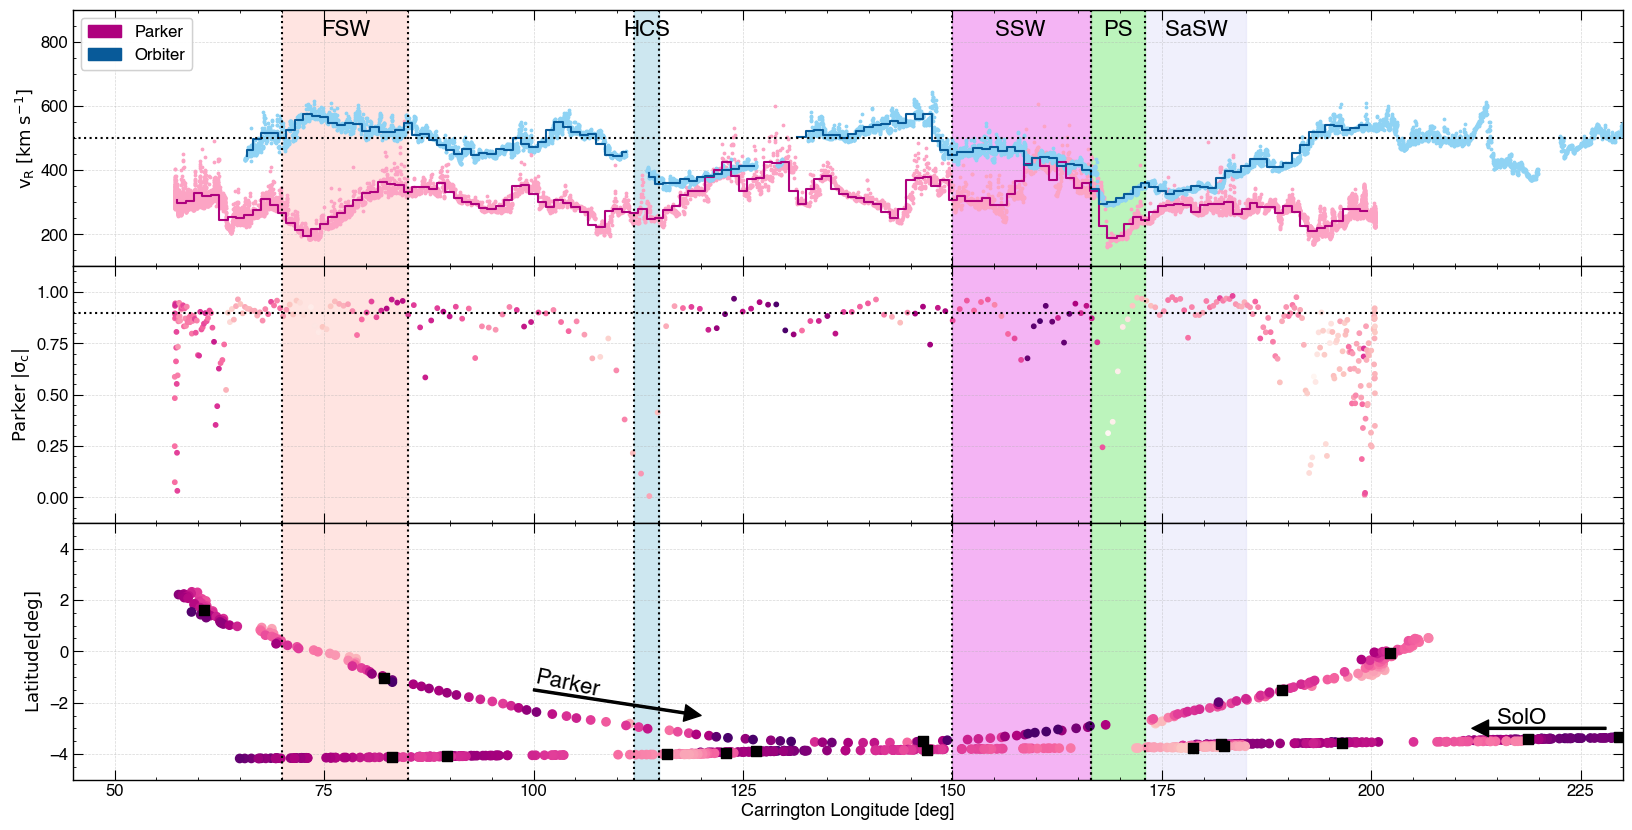

In [28]:
# create figure
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 16})
plt.style.use(plot_style)
fig, axes = plt.subplots(3, 1, figsize=[20, 10], sharex='all', gridspec_kw={'hspace': 0})

#### ---------- PANEL ONE: VELOCITY ----------- #######
# raw data
cpsp=axes[0].scatter(parker.lon,
                     parker.vr,          
                     c=lightc[0], s=3
                    )
csolo=axes[0].scatter(orbiter.lon,
                      orbiter.vr,               
                      c=lightc[1], s=3
                    )
# binned data
cpsp=axes[0].step(parkerdownl.lon,
                     parkerdownl.vr,          
                     c=c[0]
                    )
cpsp=axes[0].step(orbiterdownl.lon,
                     orbiterdownl.vr,          
                     c=c[1]
                    )
# labels 
axes[0].axhline(500, color='k', linestyle='dotted')

##### ---------- PANEL TWO: PSP CROSS HELICITY  ---------- ######
cpsp=axes[1].scatter(pss.lon,
                     np.abs(pss.sigmac), c=pss.vr,           
                     cmap='RdPu', s=10
                    )
axes[1].axhline(0.9, color='k', linestyle='dotted')


##### ---------- PANEL THREE: POSITION AS FUNC OF VELOCITY  ---------- ######
# plot date positions
axes[2].scatter(
    psp_projected.lon.to("deg")[::48],
    psp_projected.lat.to("deg")[::48]+0.3*u.deg,
    color="black",zorder=10,marker='s',s=50
)

axes[2].scatter(
    solo_projected.lon.to("deg")[::48],
    solo_projected.lat.to("deg")[::48],
    color="black",zorder=10,marker='s',s=50
)

# Normalize SolO and PSP data separately due to acceleration
normsolo=plt.Normalize(200,600) 
normpsp=plt.Normalize(100,400)

# plot full trajectory
cpsp=axes[2].scatter(psp_projected.lon,
                     psp_projected.lat+0.3*u.deg,               
                     c=psp_vr_common.value,
                     norm = normpsp,
                     cmap="RdPu"
                  )
csolo=axes[2].scatter(solo_projected.lon,
                      solo_projected.lat,               
                      c=solo_vr_common.value,
                      norm = normsolo,
                      cmap="RdPu"
                    )

###### SC MOTION #######
axes[2].text(215,-2.8,"SolO",fontsize=16,weight="bold")
axes[2].annotate(None,(212,-3),(228,-3),arrowprops=dict(facecolor='black',width=1.5))
axes[2].text(100,-1.75,"Parker",fontsize=16,weight="bold",rotation=-12)
axes[2].annotate(None,(120,-2.5),(100,-1.5),arrowprops=dict(facecolor='black',width=1.5))

###### LABELS & RANGES #######
ylabels = [r'$\rm v_R \; [km \; s^{-1}]$', r'$\rm Parker \; |\sigma_c|$', r'$\rm Latitude [deg]$']
for i, ax in enumerate(axes):
    ax.set(xlim=(45, 230), xticks=np.arange(50, 226, step=25), ylabel=ylabels[i])
    # add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    # plot hcs 
    ax.axvline(loc_hcs[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(loc_hcs[1], color='k', linestyle='dotted', zorder=5)
    ax.axvline(pseud[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(pseud[1], color='k', linestyle='dotted', zorder=5)
    ax.axvline(fsw[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(fsw[1], color='k', linestyle='dotted', zorder=5)
    ax.axvline(ssw[0], color='k', linestyle='dotted', zorder=5)
    ax.axvline(ssw[1], color='k', linestyle='dotted', zorder=5)

    # shade interesting regions
    ax.axvspan(fsw[0], fsw[1], alpha=1, color=fcol, zorder=-3)
    ax.axvspan(ssw[0], ssw[1], alpha=.6, color=scol, zorder=-3)
    ax.axvspan(sasw[0], sasw[1], alpha=.6, color=sacol, zorder=-3)
    ax.axvspan(loc_hcs[0], loc_hcs[1], alpha=.6, color=hcol, zorder=-3)
    ax.axvspan(pseud[0], pseud[1], alpha=.6, color=pcol, zorder=-3)
ax.set(xlabel='Carrington Longitude [deg]')

###### LEGEND #######
pspp = mpatches.Patch(color=c[0], label= 'Parker')
solop = mpatches.Patch(color=c[1],  label='Orbiter')
leg0 = axes[0].legend(handles=[pspp, solop], loc='upper left')
axes[0].add_artist(leg0)

###### AXES TICKS #######
axes[0].set(ylim=(100, 900), yticks=np.arange(200, 801, step=200))
axes[1].set(ylim=(-0.125, 1.125), yticks=np.arange(0, 1.1, step=0.25))
axes[2].set(ylim=(-5, 5), yticks=np.arange(-4, 4.1, step=2))


###### REGION LABELS #######
ax = axes[0]
ax.text(0.16, 0.96, 'FSW', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.text(0.355, 0.96, 'HCS', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.text(0.665, 0.96, 'PS', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.text(0.705, 0.96, 'SaSW', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
ax.text(0.595, 0.96, 'SSW', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

# save figure
plt.savefig(os.path.realpath('figures/alignment.png'), bbox_inches='tight')

## Appendix: Cross Helicity

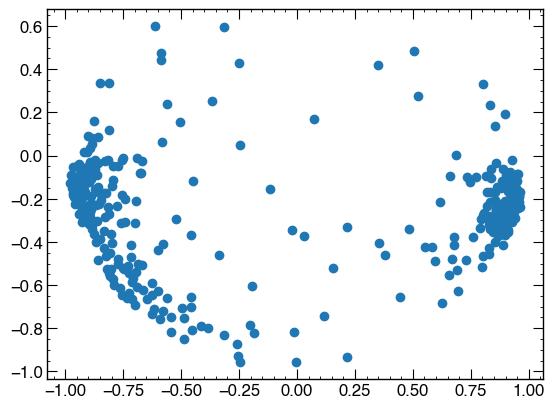

In [22]:
plt.scatter(pss.sigmac, pss.sigmar)